In [1]:
import sys

# Add the project directory to the sys.path
sys.path.append("../")
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

from src.models.navar import NAVAR
from src.utils import count_parameters, augment_with_sine, smooth_line

C:\Users\mauri\anaconda3\envs\causal-discovery\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_d = NAVAR(n_variables=3, hidden_dim=32, architecture={'kernel_size':3, 'n_blocks':3, 'n_layers_per_block':2}, dropout=0.1, weight_sharing=False, recurrent=False, aleatoric=False, epistemic=False).cuda()
model_a = NAVAR(n_variables=3, hidden_dim=32, architecture={'kernel_size':3, 'n_blocks':3, 'n_layers_per_block':2}, dropout=0.1, weight_sharing=False, recurrent=False, aleatoric=True, epistemic=False).cuda()
model_d.receptive_field

29

In [3]:
def generate_random_data():
    batch_size, sequence_length = 1, 2000
    data = (0.5 * torch.randn(batch_size, 3, sequence_length + 1)).clamp(min=-4.5, max=4.5)
    data[:, 0, [100, 400, 200, 300]] = torch.tensor([-4.5, -4, 4, 4.5])

    true_function = torch.zeros_like(data)

    # compute var 1
    for i in range(1, sequence_length + 1):
        true_function[:, 1, i] = np.sin(8 * data[:, 0, i - 1])
        data[:, 1, i] += true_function[:, 1, i]

    # compute var 2
    for i in range(1, sequence_length + 1):
        true_function[:, 2, i] = np.tanh(-4.0 * data[:, 1, i - 1])
        data[:, 2, i] += true_function[:, 2, i]

    # normalize
    d_mean, d_std = data.mean(dim=-1, keepdim=True), data.std(dim=-1, keepdim=True)
    data = (data - d_mean) / d_std
    true_function = (true_function - d_mean) / d_std

    x = data[..., :-1]
    y = data[..., 1:]
    true_function = true_function[..., 1:]

    if torch.cuda.is_available():
        x, y, true_function = x.cuda(), y.cuda(), true_function.cuda()

    return x, y, true_function


x, y, true_function = generate_random_data()
(x.size(), y.size(), true_function.size())

(torch.Size([1, 3, 2000]), torch.Size([1, 3, 2000]), torch.Size([1, 3, 2000]))

In [4]:
def train_model(model, x, y, epochs=3000, lr=1e-3):
    model.train()
    x_train = augment_with_sine(x)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    pbar = trange(epochs)
    for epoch in pbar:
        optimizer.zero_grad()
        model_out = model(x_train)
        #prediction, contributions, log_var_aleatoric

        loss = model.loss_function(y, **model_out, lambda1=0.05, coeff=0)
        
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0 or epoch == epochs - 1:
            pbar.set_description(f"Loss: {loss.item():.4f}")
        if epoch == int(0.8 * epochs):
            optimizer = optim.AdamW(model.parameters(), lr=lr/10)

    return model



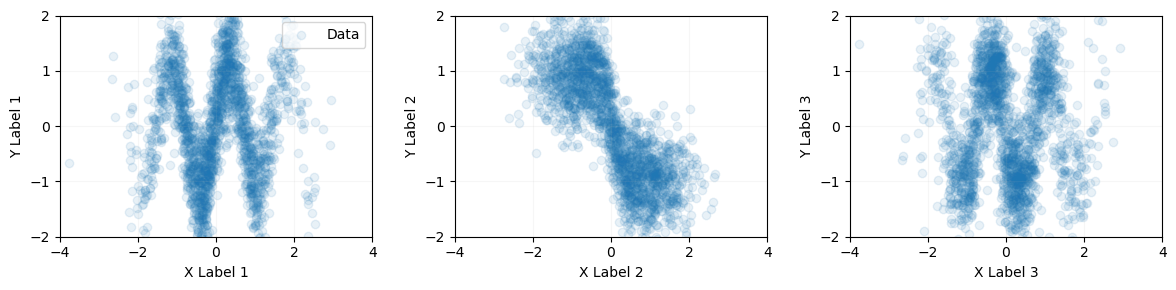

In [5]:
import matplotlib.pyplot as plt

def sort_them(inputs):
    result = [[None, None] for i in range(3)]
    for i in range(3):
        indices = np.argsort(inputs[i][0])
        for j in range(2):
            result[i][j] = inputs[i][j][indices]
    return result

def create_combined_plots(data_arrays, mean_arrays=None, std_arrays=None, default_arrays=None,
                          x_labels=None, y_labels=None, xy_limits=None, sigma=2):
    num_plots = len(data_arrays)
    
    data_arrays = sort_them(data_arrays)
    if mean_arrays is not None:
        assert num_plots == len(mean_arrays), "Number of mean arrays should match the number of plots."
        mean_arrays = sort_them(mean_arrays)
    if std_arrays is not None:
        assert num_plots == len(std_arrays), "Number of std arrays should match the number of plots."
        std_arrays = sort_them(std_arrays)
    if default_arrays is not None:
        assert num_plots == len(default_arrays), "Number of default arrays should match the number of plots."
        default_arrays = sort_them(default_arrays)

    fig, ax = plt.subplots(1, num_plots, figsize=(12, 3))
    legend_shown = False
    
    for i in range(num_plots):
        ax[i].scatter(*data_arrays[i], alpha=0.1, label='Data')
        
        if mean_arrays is not None:
            mean_smooth = smooth_line(mean_arrays[i][1], sigma=sigma)
            ax[i].plot(mean_arrays[i][0], mean_smooth, color='red', label='Mean Prediction')
            ax[i].plot(std_arrays[i][0], mean_smooth + 2 * smooth_line(std_arrays[i][1], sigma=sigma), color='green', linestyle='dashed', label='Mean ± 2*std')
            ax[i].plot(std_arrays[i][0], mean_smooth - 2 * smooth_line(std_arrays[i][1], sigma=sigma), color='green', linestyle='dashed', label='Mean ± 2*std')
        if default_arrays is not None:
            ax[i].plot(default_arrays[i][0], smooth_line(default_arrays[i][1], sigma=sigma), color='blue', linestyle='dashed', label='Default model')

        ax[i].set_xlabel(x_labels[i] if x_labels else 'X')
        ax[i].set_ylabel(y_labels[i] if y_labels else 'Y')
        ax[i].grid(alpha=0.1)
        
        if xy_limits:
            ax[i].set_xlim(xy_limits[0])
            ax[i].set_ylim(xy_limits[1])
        
        if not legend_shown:
            ax[i].legend(loc='upper right')
            legend_shown = True
            
    plt.tight_layout()
    plt.savefig('transitive.svg', format='svg')  # Save the plot as SVG
    plt.show()


x_data = x[0].cpu().numpy()


# Example usage
data_arrays = [[x_data[0, :-1], x_data[1, 1:]], [x_data[1, :-1], x_data[2, 1:]], [x_data[0, :-2], x_data[2, 2:]]]
mean_arrays = [[[1, 2, 3], [3, 4, 5]], [[4, 5, 6], [6, 7, 8]], [[7, 8, 9], [9, 10, 11]]]
std_arrays = [[[1, 2, 3], [2, 2, 2]], [[4, 5, 6], [1, 1, 1]], [[7, 8, 9], [0.5, 0.5, 0.5]]]
default_arrays = [[[1, 2, 3], [2, 2, 2]], [[4, 5, 6], [5, 5, 5]], [[7, 8, 9], [8, 8, 8]]]
x_labels = ['X Label 1', 'X Label 2', 'X Label 3']
y_labels = ['Y Label 1', 'Y Label 2', 'Y Label 3']
xy_limits = [(-4, 4), (-2, 2)]

create_combined_plots(data_arrays,None, None,None, x_labels, y_labels, xy_limits)



In [6]:
model_d = train_model(model_d, x, y, epochs=4000, lr=5e-3)
model_a = train_model(model_a, x, y, epochs=4000, lr=5e-3)

Loss: -0.2556: 100%|███████████████████████████████████████████████████████████████| 4000/4000 [01:19<00:00, 50.23it/s]


In [7]:
with torch.no_grad():
    model_d.eval()
    model_a.eval()
    out_d = model_d(augment_with_sine(x))
    out_a = model_a(augment_with_sine(x))
    prediction_d, contributions_d = out_d['prediction'][0].cpu().numpy(), out_d['contributions'][0].cpu().numpy()
    prediction_a, contributions_a, log_var_aleatoric_a = out_a['prediction'][0].cpu().numpy(), out_a['contributions'][0].cpu().numpy(), out_a['log_var_aleatoric'][0].cpu().numpy()
    std_a = np.exp(0.5 * log_var_aleatoric_a)
    model_d.train()
    model_a.train()
(x_data.shape, prediction_d.shape, contributions_d.shape, log_var_aleatoric_a.shape)

((3, 2000), (3, 2000), (3, 3, 2000), (3, 2000))

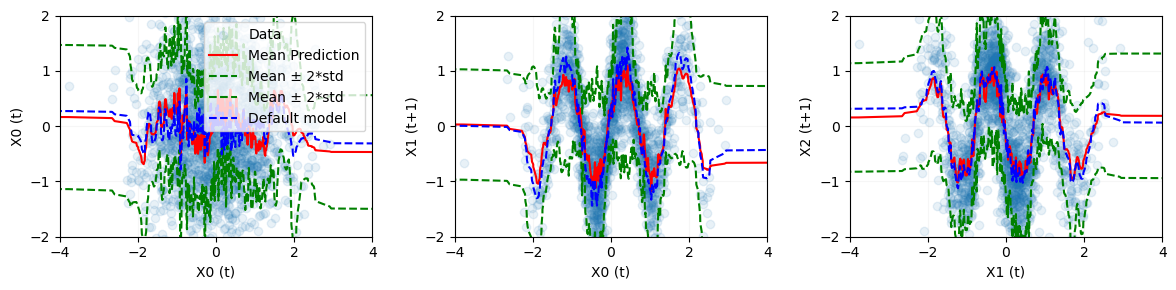

In [14]:
# Example usage
data_arrays = [      [x_data[0, :-1], x_data[0, 1:]], [x_data[0, :-1], x_data[1, 1:]], [x_data[0, :-2], x_data[2, 2:]]]
mean_arrays = [ [x_data[0], prediction_a[0]], [x_data[0], prediction_a[1]], [x_data[0, :-1], prediction_a[2, 1:]]]
std_arrays = [  [x_data[0], std_a[0]], [x_data[0], std_a[1]], [x_data[0, :-1], std_a[2, 1:]]]
default_arrays = [[x_data[0], prediction_d[0]], [x_data[0], prediction_d[1]], [x_data[0, :-1], prediction_d[2, 1:]]]
x_labels = ['X0 (t)', 'X0 (t)','X1 (t)', 'X0 (t)']
y_labels = ['X0 (t)', 'X1 (t+1)', 'X2 (t+1)', 'X2 (t+2)']
xy_limits = [(-4, 4), (-2, 2)]

create_combined_plots(data_arrays, mean_arrays, std_arrays, default_arrays, x_labels, y_labels, xy_limits, sigma=6.5)
#create_combined_plots(data_arrays, mean_arrays, None, None, x_labels, y_labels, xy_limits)

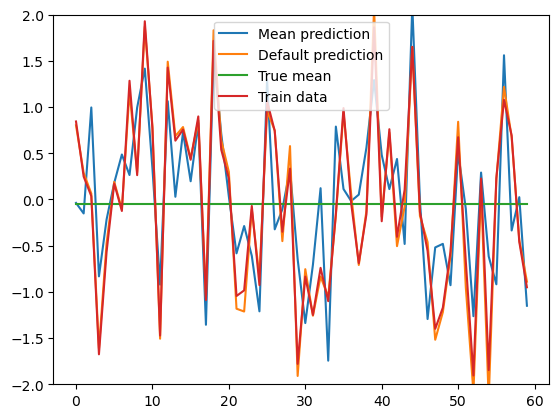

In [13]:
plt.plot(prediction_a[0, :60], label='Mean prediction')
plt.plot(prediction_d[0, :60], label='Default prediction')
plt.plot(true_function[0, 0, :60].cpu().numpy(), label='True mean')
plt.plot(x_data[0, 1:61], label='Train data')
plt.ylim((-2, 2))
plt.legend()


In [10]:
print(np.std(contributions_d, axis=-1))

[[0.48818427 0.30217943 0.45335957]
 [0.46427184 0.24864666 0.52006996]
 [0.11884148 0.88956326 0.1010165 ]]


In [11]:
print(np.std(contributions_a, axis=-1))

[[0.68582934 0.47609392 0.65124243]
 [0.41648075 0.8499969  0.5693201 ]
 [0.41284502 0.43988785 0.83976454]]
